In [32]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'scipy', 'matplotlib', 'numba']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np    # For numerical computing
import pandas as pd   # For data manipulation
import sqlite3        # For connecting to SQL database
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy import stats
from numba import njit
import os

### Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Pandas display options
pd.options.display.float_format = '{:.4f}'.format

### Getting some fuctions from the other notebook
%run 99_functions.ipynb

### Setting working directory
os.chdir('/Users/emilwilliamhansen/Desktop/Master-Thesis/Code')

In [33]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')

conn.close()

### Making sure all the data is in the same format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
volatility.index = pd.to_datetime(volatility.index)

### Fixing the index of the factor_ret_m
factor_ret_m = factor_ret_m.loc[volatility.index]

### Checking for nan
print(factor_ret_m.isna().sum().sum(), volatility.isna().sum().sum())

0 0


# Volatility timing

We will now do volatility timing of the factors. We will do almost the same thing as in `20_volatility_managed_factors.ipynb`, but we will use volatility and not variance. We will first use the market variance to time all factors, and then use the individual factors volatility.

$$r_{k,t+1}^\sigma=\frac{c}{\sigma_{k,t}} r_{k,t+1} \quad \text{ or } \quad r_{k,t+1}^\sigma=\frac{c}{\sigma_{m,t}} $$

In [34]:
### Calculating the optimal c for each factor
c = pd.DataFrame(columns=factor_ret_m.columns)
c.loc['c_fac', :] = np.nan
c.loc['c_mkt', :] = np.nan

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility[factor]).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_fac', factor] = res.x[0]

for factor in factor_ret_m.columns:
    def obj_func(c):
        vol_timed = (c / volatility['VW']).shift(1) * factor_ret_m[factor]
        return (vol_timed.std() - factor_ret_m.iloc[1:,][factor].std())**2

    res = minimize(obj_func, 0.1)
    c.loc['c_mkt', factor] = res.x[0]

### Looking at c
print(c)

### Getting the volatility timed returns
r_sigma_k, r_sigma_m = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns), pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

for factor in factor_ret_m.columns:
    r_sigma_k[factor] = (c.loc['c_fac', factor] / volatility[factor]).shift(1) * factor_ret_m[factor]
    r_sigma_m[factor] = (c.loc['c_mkt', factor] / volatility['VW']).shift(1) * factor_ret_m[factor]

### Dropping the first row in all of our returns
r_sigma_k = r_sigma_k.iloc[1:,]
r_sigma_m = r_sigma_m.iloc[1:,]
r = factor_ret_m.iloc[1:,]

          VW     EW    SMB    HML    UMD    BAB
c_fac 0.1546 0.1401 0.1414 0.1507 0.1756 0.1892
c_mkt 0.1546 0.1599 0.1690 0.1710 0.1474 0.1472


*Note:* The value of $c$ for $VW$ is equal in both scenarios, and the reutrns will also be identical by construction.

# Mean-variance optimazation

We will now use a expanding window approch, where we start with a window of 120 months to pick weights for three portfolios. The three portfolios are:

 - Uncondtional Mean-Variance portfolio (UMV): The mean-variance portfolio for a invstor only investing in the orginal factors.
 - Contional Mean-Variance portfolio using factor volatility ($CMV_{f}$): The mean-variance portfolio for a invstor  investing in the orginal factors and the volatility-managed, based on it's own past volatility, version of the factor. 
 - Contional Mean-Variance portfolio using factor volatility ($CMV_{m}$): The mean-variance portfolio for a invstor  investing in the orginal factors and the volatility-managed, based on the market's past volatility, version of the factor. 

In [35]:
### Defining the starting window size
window = 120

### Creating a place to store the returns
MV = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]
MV_is = pd.DataFrame(columns=[['UMV', 'CMV_k', 'CMV_m']], index=r.index).iloc[window:,]

### Getting the data we need for the expanding window
data_o = r
data_m = pd.concat([r, r_sigma_m], axis=1)
data_k = pd.concat([r, r_sigma_k], axis=1)

### Getting the in-sample weights
w_o_is = ptf_weights(data_o.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_m_is = ptf_weights(data_m.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
w_k_is = ptf_weights(data_k.iloc[window:,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

### Getting the in-sample returns
MV_is.loc[:, 'UMV'] = (w_o_is * data_o.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_m'] = (w_m_is * data_m.iloc[window:,]).sum(axis=1)
MV_is.loc[:, 'CMV_k'] = (w_k_is * data_k.iloc[window:,]).sum(axis=1)

### Running the loop
for i in range(window, len(r)):
    ## Getting the weights
    w_o = ptf_weights(data_o.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_m = ptf_weights(data_m.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')
    w_k = ptf_weights(data_k.iloc[:i,], negative=False, type='MVP', gamma = 5, wanted_weight='None')

    ## Getting the returns
    MV.loc[r.index[i], 'UMV'] = (w_o * data_o.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_k'] = (w_m * data_k.iloc[i,]).sum()
    MV.loc[r.index[i], 'CMV_m'] = (w_k * data_m.iloc[i,]).sum()

In [36]:
data = pd.concat([MV, MV_is], axis=1)
data

,UMV,CMV_k,CMV_m,UMV,CMV_k,CMV_m
Date,,,,,,
1993-02-28,0.1823,0.2049,0.1822,0.4007,0.3695,0.3633
1993-03-31,0.1170,0.1322,0.1320,0.2619,0.2633,0.2677
1993-04-30,0.1464,0.1744,0.1665,0.2277,0.2285,0.2394
1993-05-31,0.0832,0.1015,0.1027,0.1908,0.1792,0.2381
1993-06-30,0.1763,0.1513,0.2220,0.1841,0.1600,0.2107
...,...,...,...,...,...,...
2023-08-31,-0.0373,-0.0681,-0.0636,-0.0536,-0.0725,-0.0697
2023-09-30,0.0903,0.1358,0.1086,0.1107,0.1293,0.1265
2023-10-31,-0.0595,-0.0917,-0.1046,-0.0782,-0.0866,-0.1267


In [37]:
### Getting the p-values
p_values = pd.DataFrame(columns=MV.columns, index=['In-Sample', 'Out-of-Sample'])

### Number of simulations
n_boot = 10000

### Getting the data we need
data = pd.concat([MV, MV_is], axis=1)

### Loop for in-sample or out-of-sample
for s in [0,1]:

    ### Loop for factor or market
    for f in [1,2]:

        ## Creating a list to store the differences
        diff = []

        ## Loop for the bootstrap
        for i in range(n_boot):
            # Getting the bootstrapped returns
            boot = stationary_bootstrap(np.array(data.iloc[:, [(0+s*3), (f+s*3)]].astype(float)), 5, len(data))

            # Adding the difference to the list
            diff.append(sharpes_ratio(boot[:,0]) - sharpes_ratio(boot[:,1]))

        ## Getting the p-value
        p_values.iloc[s,f] = (np.sum(np.array(diff) > 0) / (len(diff)))

### Looking at the p-values
p_values


,UMV,CMV_k,CMV_m
In-Sample,NaN,0.6779,0.2573
Out-of-Sample,NaN,0.2393,0.0303


Now we will get the alphas running the following regression

$$CMV = \alpha + \beta \times UMV + \epsilon$$

In [38]:
### Getting the alphas
X = MV['UMV'].astype(float)
X = sm.add_constant(X)
y = MV['CMV_k'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_k = model.params['const']
tstat_alpha_k = model.tvalues['const']
print(f'Annualized alpha using factor volatility: {alpha_k*12:.3f}, t-stat: {tstat_alpha_k:.3f}')

y = MV['CMV_m'].astype(float)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
alpha_m = model.params['const']
tstat_alpha_m = model.tvalues['const']
print(f'Annualized alpha using market volatility: {alpha_m*12:.3f}, t-stat: {tstat_alpha_m:.3f}')

Annualized alpha using factor volatility: 0.017, t-stat: 0.670
Annualized alpha using market volatility: 0.068, t-stat: 2.059


# Visuals

In [39]:
### Creating  a latex table
latex = pd.DataFrame(columns=['UMV', 'CMV_k', 'CMV_m'], index=['Mean', 'Standard deviation', 'Sharpe ratio', 'p-value', 'alpha', 't(alpha)'])

latex.loc['Mean', :] = MV.mean().values * 12
latex.loc['Standard deviation', :] = MV.std().values * np.sqrt(12)
latex.loc['Sharpe ratio', :] = sharpes_ratio(MV).values
latex.loc['p-value', 'CMV_k'] = p_values.iloc[1,1]
latex.loc['p-value', 'CMV_m'] = p_values.iloc[1,2]
latex.loc['alpha', 'CMV_k'] = alpha_k * 12 * 100
latex.loc['alpha', 'CMV_m'] = alpha_m * 12 * 100
latex.loc['t(alpha)', 'CMV_k'] = tstat_alpha_k
latex.loc['t(alpha)', 'CMV_m'] = tstat_alpha_m

print(latex.to_latex(float_format="%.3f", na_rep=""))

\begin{tabular}{llll}
\toprule
 & UMV & CMV_k & CMV_m \\
\midrule
Mean & 0.500 & 0.576 & 0.574 \\
Standard deviation & 0.306 & 0.360 & 0.330 \\
Sharpe ratio & 1.633 & 1.598 & 1.742 \\
p-value &  & 0.239 & 0.030 \\
alpha &  & 1.696 & 6.797 \\
t(alpha) &  & 0.670 & 2.059 \\
\bottomrule
\end{tabular}



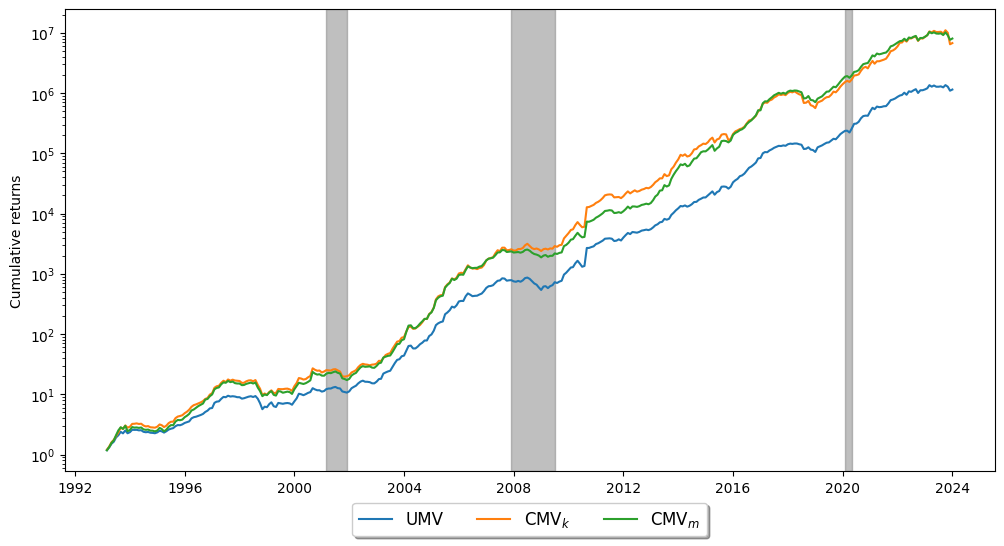

In [40]:
### Plotting cumulative returns for all the 3 portfolios in MV
plt.figure(figsize=(12, 6))
plt.plot((1 + MV).cumprod())
plt.ylabel('Cumulative returns')
plt.legend(['UMV', r'CMV$_{k}$', r'CMV$_{m}$'], loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=3, fontsize='large')
plt.yscale('log')

recessions = [
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Add grey fields for recessions
for start, end in recessions:
    plt.axvspan(start, end, color='grey', alpha=0.5)

plt.savefig('Plots/cumulative_returns_ptfs.png')
plt.show()